In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import geopandas as gpd
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression

static_features = ["awc", "bulk_density", "drainage_class_4", "drainage_class_5", "drainage_class_6"]
temporal_prefixes = ["tavg", "prec", "tmin", "tmax", "ndvi", "fpar", "rad", "et0", "cwb", "ssm", "rsm"]
statefp_to_name = {'08':'Colorado', '20':'Kansas', '31':'Nebraska', '40':'Oklahoma', '46':'South Dakota', '48':'Texas'}
truncation_to_date = {
    "3_23": "05 Aug", "3_22": "19 Jul", "3_21": "03 Jul",
    "3_20": "17 Jun", "3_19": "01 Jun", "3_18": "16 May",
    "3_17": "30 Apr", "3_16": "14 Apr", "3_15": "29 Mar",
    "3_14": "13 Mar", "3_13": "25 Feb", "3_12": "09 Feb",
    "3_11": "24 Jan", "3_10": "08 Jan", "3_9": "26 Dec",
    "3_8": "10 Dec", "3_7": "24 Nov", "3_6": "08 Nov",
    "3_5": "23 Oct", "3_4": "07 Oct", "3_3": "21 Sep"
}

### 1. Analyse performance metrics

In [7]:
pred_true = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_20_june_ba_scm_v2.csv").drop(columns=["Unnamed: 0"])
features = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/cy_bench_16daybins_wheat_US_v8.csv')
yield_df = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/CY-Bench/US/wheat/yield_wheat_US.csv')	
us_shape = gpd.read_file("data/shapefiles/US/tl_2023_us_county.shp")

# YIELD DF
yield_df = yield_df.rename(columns={"harvest_year":"year"})

# US GEODATA
us_shape = us_shape.assign(adm_id="US-"+us_shape["STATEFP"] + "-" + us_shape["COUNTYFP"])[["adm_id", "geometry", "STATEFP"]]
us_counties = us_shape.loc[us_shape["STATEFP"].isin(['08', '20', '31', '40', '46', '48'])].reset_index(drop=True)
us_counties["STATEFP"] = us_counties["STATEFP"].apply(lambda x: statefp_to_name[x])
us_states = us_counties[["STATEFP", "geometry"]].dissolve(by="STATEFP").reset_index()

# RESULTS
xy = (features.loc[(features["adm_id"].isin(pred_true["adm_id"].unique())) & (features["harvest_year"].isin(pred_true["year"].unique())), 
        ["adm_id", "harvest_year", "yield_-5", "yield_-4", "yield_-3", "yield_-2", "yield_-1"]]
        .rename(columns={"harvest_year":"year"})
        .merge(pred_true, on=["adm_id", "year"], how="right")
        .rename(columns={"y_true": "yield"})
        .assign(threeyearavg = lambda x: x[["yield_-3", "yield_-2", "yield_-1"]].mean(axis=1),
                fiveyearavg = lambda x: x[["yield_-5", "yield_-4", "yield_-3", "yield_-2", "yield_-1"]].mean(axis=1))
        .drop(columns=["yield_-1", "yield_-2", "yield_-3", "yield_-4", "yield_-5"])
        .merge(us_counties[["STATEFP", "adm_id"]], on="adm_id", how="left")
        .merge(yield_df[["adm_id", "year", "harvest_area"]], how="left", on=["adm_id", "year"])
)

xy = (yield_df.loc[(yield_df["adm_id"].isin(pred_true["adm_id"].unique())) & (yield_df["year"] < 2021),
             ["adm_id", "year", "harvest_area"]].sort_values(by=["adm_id", "year"], ascending=False).groupby("adm_id").head(5).groupby("adm_id")["harvest_area"].mean()
 .reset_index().rename(columns={"harvest_area":"harvest_area_5yravg"}).merge(xy, on="adm_id", how="right")
 .assign(county_mean=(xy["yield"]+3*xy["threeyearavg"]) / 4))

In [5]:
state_year_level = xy.groupby(['STATEFP', 'year']).apply(
    lambda x: pd.Series({
        'weighted_y_pred': np.average(x['y_pred'], weights=x['harvest_area_5yravg']),
        'weighted_threeyearavg': np.average(x['threeyearavg'], weights=x['harvest_area']),
        'weighted_fiveyearavg': np.average(x['fiveyearavg'], weights=x['harvest_area']),
        'weighted_yield': np.average(x['yield'], weights=x['harvest_area'])
    })
).reset_index()

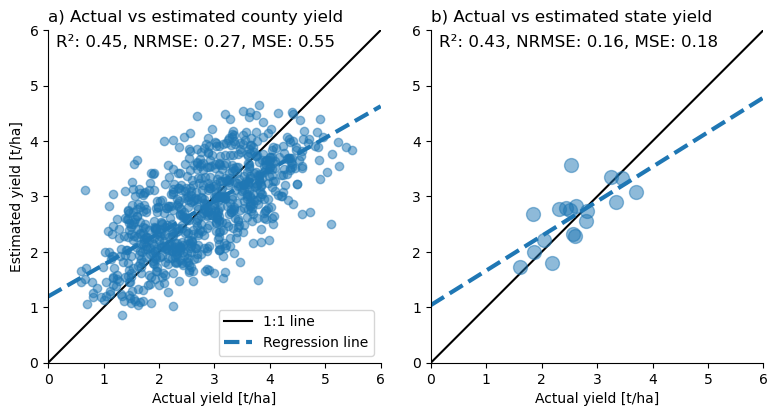

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for county-level data on ax[0]
ax[0].plot([0, 6], [0, 6], "black", label="1:1 line")
ax[0].set_aspect('equal', adjustable='box')
ax[0].plot(xy["yield"], xy["y_pred"], "o", alpha=0.5)
slope, bias = np.polyfit(xy["yield"], xy["y_pred"], 1)
ax[0].plot([0, 6], [bias, slope * 6 + bias], color='C0', linewidth=3, linestyle="--", label="Regression line")
ax[0].legend(loc="lower right")
ax[0].set_xlim(0, 6)
ax[0].set_ylim(0, 6)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title("a) Actual vs estimated county yield", loc="left")
ax[0].set_xlabel("Actual yield [t/ha]")
ax[0].set_ylabel("Estimated yield [t/ha]")

# Compute the metrics for county-level data
r2 = round(r2_score(xy["yield"], xy["y_pred"]), 2)
nrmse = round(root_mean_squared_error(xy["yield"], xy["y_pred"]) / xy["yield"].mean(), 2)
mse = round(np.mean((xy["yield"] - xy["y_pred"])**2), 2)

# Add text with metrics to the plot
ax[0].text(0.15, 5.7, f"R²: {r2}, NRMSE: {nrmse}, MSE: {mse}", fontsize=12)

# Plot for state-level data on ax[1]
ax[1].plot([0, 6], [0, 6], "black")
ax[1].set_aspect('equal', adjustable='box')
ax[1].plot(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"], "o", alpha=0.5, markersize=10)
slope, bias = np.polyfit(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"], 1)
ax[1].plot([0, 6], [bias, slope * 6 + bias], color='C0', linewidth=3, linestyle="--")

ax[1].set_xlim(0, 6)
ax[1].set_ylim(0, 6)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title("b) Actual vs estimated state yield", loc="left")
ax[1].set_xlabel("Actual yield [t/ha]")
#ax[1].set_ylabel("Estimated yield [t/ha]")

# Compute the metrics for state-level data
r2_state = round(r2_score(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"]), 2)
nrmse_state = round(root_mean_squared_error(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"]) / state_year_level["weighted_yield"].mean(), 2)
mse_state = round(np.mean((state_year_level["weighted_yield"] - state_year_level["weighted_y_pred"])**2), 2)

# Add text with metrics to the plot
ax[1].text(0.15, 5.7, f"R²: {r2_state}, NRMSE: {nrmse_state}, MSE: {mse_state}", fontsize=12)

plt.tight_layout()
plt.show()

Geoplot

In [5]:
state_year_level = state_year_level.assign(state_mean=(state_year_level["weighted_yield"]+3*state_year_level["weighted_threeyearavg"]) / 4)

state_rmse = state_year_level.groupby('STATEFP').apply(lambda x: np.sqrt(np.mean((x['weighted_yield'] - x['weighted_y_pred'])**2))).reset_index(name='RMSE')
state_rmse = state_rmse.merge(state_year_level[['STATEFP', 'state_mean']].groupby("STATEFP")["state_mean"].mean().reset_index(), on='STATEFP')
state_rmse['rRMSE'] = 100 * state_rmse['RMSE'] / state_rmse['state_mean']
state_rmse_gdf = us_states.merge(state_rmse, on='STATEFP')

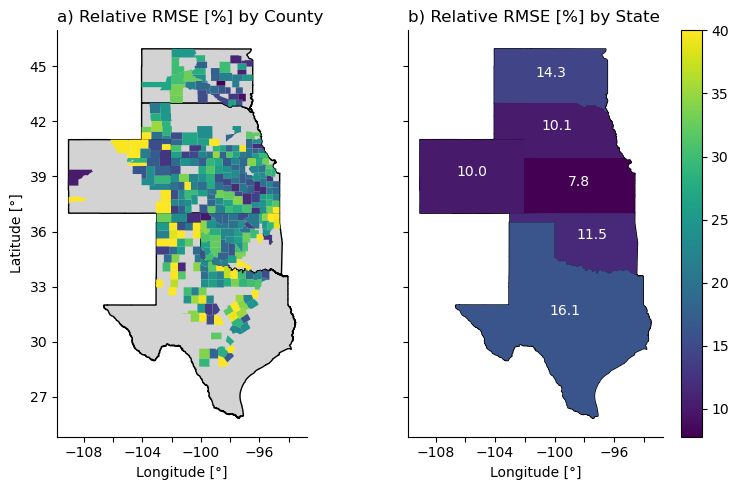

In [6]:
# Calculate rRMSE for each county
rmse_df = xy.groupby('adm_id').apply(lambda x: np.sqrt(np.mean((x['yield'] - x['y_pred'])**2))).reset_index(name='RMSE')
mean_county_mean_df = xy.groupby('adm_id')['county_mean'].mean().reset_index(name='mean_county_mean')
rmse_df = rmse_df.merge(mean_county_mean_df, on='adm_id')
rmse_df['rRMSE'] = 100 * rmse_df['RMSE'] / rmse_df['mean_county_mean']
rmse_gdf = us_counties.merge(rmse_df, on='adm_id')

# Plot the rRMSE values
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

# Plot for county-level data on ax[0]
us_states.plot(color='lightgrey', edgecolor='black', ax=ax[0])
rmse_gdf.plot(column='rRMSE', cmap='viridis', vmax=40, legend=False, ax=ax[0])
ax[0].set_title('a) Relative RMSE [%] by County', loc='left')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Longitude [°]')
ax[0].set_ylabel('Latitude [°]')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for label in ax[0].get_xticklabels()[::2]:
    label.set_visible(False)
ax[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot for state-level data on ax[1]
us_states.plot(color='lightgrey', edgecolor='black', ax=ax[1])
state_rmse_gdf.plot(column='rRMSE', cmap='viridis', vmax=40, legend=True, ax=ax[1])
ax[1].set_title('b) Relative RMSE [%] by State', loc='left')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Longitude [°]')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for label in ax[1].get_xticklabels()[::2]:
    label.set_visible(False)
ax[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add rRMSE values to the state polygons
for idx, row in state_rmse_gdf.iterrows():
    ax[1].annotate(text=f"{row['rRMSE']:.1f}", xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                   ha='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store the metrics
years = []
rmses = []
mses = []
r2s = []
rmses_baseline = []
mses_baseline = []
r2s_baseline = []

# Loop through each year in the DataFrame
for year in xy['year'].unique():
    xy_year = xy[xy['year'] == year]
    y_true = xy_year['yield']
    y_pred = xy_year['y_pred']
    y_baseline = xy_year['threeyearavg']
    
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) / y_true.mean()
    mse = np.mean((y_true - y_pred)**2)
    r2 = r2_score(y_true, y_pred)
    
    rmse_baseline = np.sqrt(np.mean((y_true - y_baseline)**2)) / y_true.mean()
    mse_baseline = np.mean((y_true - y_baseline)**2)
    r2_baseline = r2_score(y_true, y_baseline)
    
    years.append(year)
    rmses.append(rmse)
    mses.append(mse)
    r2s.append(r2)
    rmses_baseline.append(rmse_baseline)
    mses_baseline.append(mse_baseline)
    r2s_baseline.append(r2_baseline)

# Create a DataFrame to store the results
metrics_by_year = pd.DataFrame({
    'Year': years,
    'RMSE LSTM': rmses,
    'RMSE Trend': rmses_baseline,
    'MSE LSTM': mses,
    'MSE Trend': mses_baseline,
    'R² LSTM': r2s,    
    'R² Trend': r2s_baseline
})

metrics_by_year.sort_values(by="Year").reset_index(drop=True).round(2)

,Year,RMSE LSTM,RMSE Trend,MSE LSTM,MSE Trend,R² LSTM,R² Trend
0,2021,0.22,0.22,0.45,0.42,0.42,0.45
1,2022,0.25,0.34,0.42,0.79,0.62,0.29
2,2023,0.27,0.34,0.55,0.86,0.49,0.19


In [9]:
scm_to_truncation = {"may":18, "june":19, "july":22}

In [4]:
scm_may = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_22_june_ba_prec_scm_v2.csv")
print(np.mean((scm_may["y_true"] - scm_may["y_pred"])**2))

0.5813613164369839


In [7]:
scm_may = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_21_may_ba_prec_scm_v2.csv")
print(np.mean((scm_may["y_true"] - scm_may["y_pred"])**2))

0.5717279262828474


In [16]:
scm_may = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_19_may_ba_allvars_scm_v2.csv")
print(np.mean((scm_may["y_true"] - scm_may["y_pred"])**2))

0.6038165828791882


In [8]:
scm_may = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_20_june_ba__no_prec_scm_v2.csv")
print(np.mean((scm_may["y_true"] - scm_may["y_pred"])**2))

0.5361207610636604


In [11]:
scm_may = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_21_june_ba_prectavg_scm_v2.csv")
print(np.mean((scm_may["y_true"] - scm_may["y_pred"])**2))

0.561113347845668


In [17]:
df = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_19_double_check.csv")

In [21]:
df2 = pd.read_csv("data/results/test_y_true_y_pred_timesteps_3_19.csv")

In [22]:
df2

,Unnamed: 0,y_true,y_pred,adm_id,year
0,2988,1.91132,3.430489,US-08-069,2022
1,2995,2.95447,2.025579,US-08-075,2023
2,2996,1.61520,1.856412,US-08-075,2022
3,2997,3.02177,2.687923,US-08-075,2021
4,3007,1.87767,2.177902,US-08-087,2022
...,...,...,...,...,...
769,6740,2.11995,2.312512,US-48-325,2021
770,6758,1.46041,1.892917,US-48-493,2022
771,6769,3.78899,0.913002,US-48-013,2022
772,6780,2.12668,2.039078,US-48-507,2023


In [14]:
import os

# List all files in the "data/results/" directory
filenames = os.listdir("data/results/")
# Filter filenames that start with "test" and end with ".csv"
test_filenames = [f for f in filenames if ((f.startswith("test") and f.endswith(".csv"))
                                           and ("scm" not in f))]

# Read each file into a dataframe and store them in a list
dfs = []
for file in test_filenames:
    df = pd.read_csv(os.path.join("data/results/", file))
    truncation = "_".join(file.replace(".csv", "").split("_")[-2:])
    df["truncation"] = truncation
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.drop("Unnamed: 0", axis=1, inplace=True)
# Calculate the mean squared error for each truncation
mse_by_truncation = combined_df.groupby("truncation").apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE')
mse_by_truncation = mse_by_truncation.assign(limit=mse_by_truncation["truncation"].str.split("_", expand=True)[1].astype(int))
mse_by_truncation["truncation"] = mse_by_truncation["truncation"].map(truncation_to_date)
mse_by_truncation = mse_by_truncation.sort_values(by="limit").reset_index(drop=True)
mse_by_truncation

,truncation,MSE,limit
0,21 Sep,0.630064,3
1,07 Oct,0.667334,4
2,23 Oct,0.715510,5
3,08 Nov,0.745141,6
4,24 Nov,0.749373,7
5,10 Dec,0.714859,8
6,26 Dec,0.758659,9
7,08 Jan,0.720415,10
8,24 Jan,0.672205,11
9,09 Feb,0.636544,12


NameError: name 'xy' is not defined

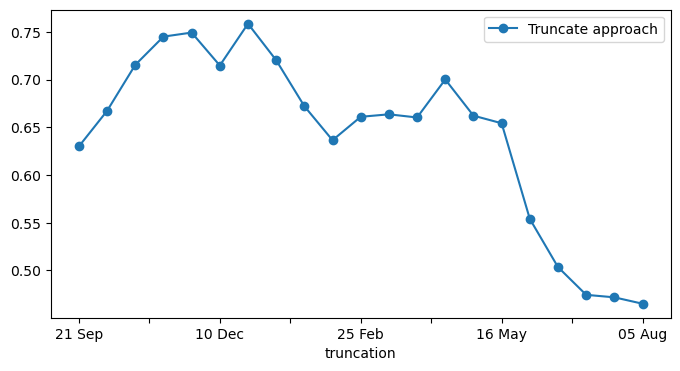

In [3]:
mse_by_truncation.plot(x="truncation", y="MSE", label="Truncate approach", marker="o")
plt.gcf().set_size_inches(8, 4)
plt.plot([0, 19], 2*[np.mean((xy["yield"] - xy["threeyearavg"])**2)], label="Three-year average", linestyle="--")
plt.plot([0, 19], 2*[np.mean((xy["yield"] - xy["y_pred"])**2)], label="End-of-season LSTM", color='C0',linestyle="--")
plt.legend(loc="lower left")
plt.xlabel("Truncation date")
plt.ylabel("Mean squared error [t/ha]")
plt.xticks(ticks=range(len(mse_by_truncation["truncation"])), labels=mse_by_truncation["truncation"], rotation=45)
plt.title("Mean squared error by truncation date", loc="left")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



In [48]:
mse_by_truncation.iloc[-1]

truncation      05 Aug
MSE           0.465153
Name: 8, dtype: object

In [84]:
print(round(1 - sum((xy["yield"] - xy["y_pred"])**2) / sum((xy["yield"] - xy["threeyearavg"])**2), 2))
#print(round(1 - sum((xy["yield"] - xy["y_pred"])**2) / sum((xy["yield"] - xy["fiveyearavg"])**2), 2))

for year in [2021, 2022, 2023]:
    xy_year = xy[xy["year"] == year]
    print(f"Year {year}:")
    print(round(1 - sum((xy_year["yield"] - xy_year["y_pred"])**2) / sum((xy_year["yield"] - xy_year["threeyearavg"])**2), 2))
    #print(round(1 - sum((xy_year["yield"] - xy_year["y_pred"])**2) / sum((xy_year["yield"] - xy_year["fiveyearavg"])**2), 2))

0.31
Year 2021:
-0.05
Year 2022:
0.46
Year 2023:
0.37


In [3]:
pred_true = pd.read_csv("test_y_true_y_pred_timesteps_3_23.csv")

print("R2 score when using great plains mean yield:", np.round(r2_score(pred_true["y_true"], pred_true["y_pred"]), 2))

filtered_yield = yield_df.loc[(yield_df["adm_id"].isin(pred_true["adm_id"])) & (yield_df["harvest_year"] < 2018), ["adm_id", "harvest_year", "yield"]].reset_index(drop=True)
filtered_yield = filtered_yield.assign(mean_yield = filtered_yield.groupby("adm_id")["yield"].transform("mean"))
val_yield = yield_df.loc[(yield_df["adm_id"].isin(pred_true["adm_id"])) & (yield_df["harvest_year"].isin([2018, 2019, 2020])), ["adm_id", "harvest_year", "yield"]].reset_index(drop=True)
numerator = sum((pred_true["y_true"] - pred_true["y_pred"])**2)
denominator = val_yield.merge(filtered_yield[["adm_id", "mean_yield"]].drop_duplicates(), on=["adm_id"], how="inner").assign(squared_error=lambda x: (x["yield"] - x["mean_yield"])**2)["squared_error"].sum()
r2_score_scratch = 1 - (numerator / denominator)

print("R2 score with adm-level mean yield from training set:", np.round(r2_score_scratch, 2))

yield_last_three_years = features.loc[(features["adm_id"].isin(pred_true["adm_id"].unique())) & (features["harvest_year"].isin([2018, 2019, 2020])), ["adm_id", "harvest_year", "yield_-1", "yield_-2", "yield_-3"]].reset_index(drop=True)  
yield_last_three_years = yield_last_three_years.merge(yield_df[["adm_id", "harvest_year", "yield"]], on=["adm_id", "harvest_year"], how="inner").assign(previous_yield_mean=lambda x: x[["yield_-1", "yield_-2", "yield_-3"]].mean(axis=1))
numerator = sum((pred_true["y_true"] - pred_true["y_pred"])**2)
denominator = yield_last_three_years.assign(squared_error=lambda x: (x["yield"] - x["previous_yield_mean"])**2)["squared_error"].sum()
r2_score_scratch = 1 - (numerator / denominator)

print("R2 score with adm-level mean yield from three previous years:", np.round(r2_score_scratch, 2))

us_wheat_mean = yield_df.loc[yield_df['harvest_year'].isin([2018, 2019, 2020]), "yield"].mean()
numerator = sum((pred_true["y_true"] - pred_true["y_pred"])**2)
denominator = sum((pred_true["y_true"] - us_wheat_mean)**2)
r2_score_scratch = 1 - (numerator / denominator)

print("R2 score with national mean yield:", np.round(r2_score_scratch, 2))

R2 score when using great plains mean yield: 0.55
R2 score with adm-level mean yield from training set: 0.15
R2 score with adm-level mean yield from three previous years: 0.04
R2 score with national mean yield: 0.8


#### 1. Calculate MI Score over training years

In [3]:
features = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/cy_bench_16daybins_wheat_US_v8.csv')
yield_df = pd.read_csv("C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/CY-Bench/US/wheat/yield_wheat_US.csv")
xy = features.merge(yield_df, on=["harvest_year", "adm_id"], how="inner")
xy = xy.loc[xy["harvest_year"] < 2018].reset_index(drop=True)
xy["state"] = xy["adm_id"].apply(lambda x: x.split("-")[1])

In [4]:
# Extract temporal columns
temporal_columns = [col for col in xy.columns if any(col.startswith(prefix) for prefix in temporal_prefixes)]

# Calculate mutual information regression scores
mi_scores = mutual_info_regression(xy[temporal_columns], xy['yield'])
mean_mi_score = np.mean(mi_scores)

print("Mean Mutual Information Regression Score:", mean_mi_score)

# Calculate mutual information regression scores for each temporal column
mi_scores_dict = dict(zip(temporal_columns, mi_scores))
average_mi_scores = {prefix: [] for prefix in temporal_prefixes}
for col, score in mi_scores_dict.items():
    for prefix in temporal_prefixes:
        if col.startswith(prefix):
            average_mi_scores[prefix].append(score)
            break
average_mi_scores = {prefix: np.mean(scores) for prefix, scores in average_mi_scores.items()}
print("Average Mutual Information Regression Scores by Temporal Prefix:")
for prefix, avg_score in average_mi_scores.items():
    print(f"{prefix}: {round(avg_score, 4)}")

Mean Mutual Information Regression Score: 0.09942177186539398
Average Mutual Information Regression Scores by Temporal Prefix:
tavg: 0.1323
prec: 0.0507
tmin: 0.1208
tmax: 0.1361
ndvi: 0.0632
fpar: 0.087
rad: 0.119
et0: 0.1452
cwb: 0.0925
ssm: 0.0748
rsm: 0.0719
